# Final Project

# *1C Company* - Predict Future Sales

**Motivation**

This challenge serves as final project for the Coursera course "How to win a data science competition". In this competition I will work with a challenging time-series dataset consisting of daily sales data. The sales data is kindly provided by one of the largest Russian software firms - 1C Company. 

The task is to **predict the total amount of products sold in every shop for the test set in the next month**. 

Submissions are evaluated by **root mean squared error** (RMSE). True target values are clipped into [0,20] range.

Source: https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview

## Table of contents

###  [1. Importing data](#Getting1)
###  [2. Data preprocessing and feature extraction](#Preprocessing2)
&nbsp;&nbsp;&nbsp;[2.1 Data cleaning](#Clear21)  
&nbsp;&nbsp;&nbsp;[2.2 Extracting categorical features from item names](#Extracting22)  
&nbsp;&nbsp;&nbsp;[2.3 ID values of Train and test data](#Making23)   
&nbsp;&nbsp;&nbsp;[2.4 Text features with TF-IDF](#Text24)      
&nbsp;&nbsp;&nbsp;[2.5 Feature matrix](#Feature27)  
###  [3. Exploratory data analysis](#Exploratory3) 
###  [4. Advanced feature engineering](#Advanced4)   
&nbsp;&nbsp;&nbsp;[4.1 Matrix factorization on text processed features](#Matrix42)  
&nbsp;&nbsp;&nbsp;[4.2 Mean encoding on categorical features](#Mean41)  
&nbsp;&nbsp;&nbsp;[4.3 Last sales month](#Last)  
&nbsp;&nbsp;&nbsp;[4.4 Creating lag features](#lag)  
&nbsp;&nbsp;&nbsp;[4.5 Sale stats in recent](#stats)  
&nbsp;&nbsp;&nbsp;[4.6 Consecutive_month_number](#consecutive)  
&nbsp;&nbsp;&nbsp;[4.7 StandardScaler](#Simple43)   
&nbsp;&nbsp;&nbsp;[4.8 Simple feature selection](#Simple48)  
###  [5. Model training](#Model5)   
&nbsp;&nbsp;&nbsp;[5.1 Validation scheme](#Validation51)   
&nbsp;&nbsp;&nbsp;[5.2 Baseline](#XGBoost53)  
&nbsp;&nbsp;&nbsp;[5.3 Feature importance](#Linear54)  
###  [6. Ensembling and test predictions](#Ensembling6)   
&nbsp;&nbsp;&nbsp;[6.1 Ensembling: XGBoost + Linear Regression](#Ensembling61)  
&nbsp;&nbsp;&nbsp;[6.2 Leaderboard](#Leaderboard62)  
###  [7. Conclusion](#Conclusion)       
###  [8. Reference](#Reference)     
&nbsp;&nbsp;&nbsp;  

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import seaborn as sns

import pickle
import gc
import os
import time
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import text
from sklearn.model_selection import KFold #StratifiedKFold
from sklearn.decomposition import NMF #PCA, TruncatedSVD, 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb

pd.set_option('display.max_columns', None)

/Users/brian/miniconda3/envs/data_science_env/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Part 1/8: Importing data<a name="Getting1"></a>

# mount my google drive, only used when i use colab to do computation
from google.colab import drive
drive.mount('/content/drive')

In [3]:
#DATA_FOLDER = '../input/'  # kaggle data folder
DATA_FOLDER = '../readonly/final_project_data/' # data folder on my Mac Pro
# data folder on google colab
#DATA_FOLDER = './drive/My Drive/Colab Notebooks/final_project_data/'  

sales_train    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv'))
items          = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
test           = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops          = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
#Check shape
print('shape: \n', sales_train.shape)
print('\n')
print('dtypes: \n', sales_train.dtypes)
print('\n')
print('number of unique value: \n', sales_train.nunique())

shape: 
 (2935849, 6)


dtypes: 
 date               object
date_block_num      int64
shop_id             int64
item_id             int64
item_price        float64
item_cnt_day      float64
dtype: object


number of unique value: 
 date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64


In [6]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


#### Note
Here we can see min item_price is negative. It is strange and need to deal with.

In [7]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [8]:
print('shape: \n', test.shape)
print('\n')
print('dtypes: \n', test.dtypes)
print('\n')
print('number of unique value: \n', test.nunique())

shape: 
 (214200, 3)


dtypes: 
 ID         int64
shop_id    int64
item_id    int64
dtype: object


number of unique value: 
 ID         214200
shop_id        42
item_id      5100
dtype: int64


In [9]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [10]:
print('shape: \n', items.shape)
print('\n')
print('dtypes: \n', items.dtypes)
print('\n')
print('number of unique value: \n', items.nunique())

shape: 
 (22170, 3)


dtypes: 
 item_name           object
item_id              int64
item_category_id     int64
dtype: object


number of unique value: 
 item_name           22170
item_id             22170
item_category_id       84
dtype: int64


In [11]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [12]:
print('shape: \n', item_categories.shape)
print('\n')
print('dtypes: \n', item_categories.dtypes)
print('\n')
print('number of unique value: \n', item_categories.nunique())

shape: 
 (84, 2)


dtypes: 
 item_category_name    object
item_category_id       int64
dtype: object


number of unique value: 
 item_category_name    84
item_category_id      84
dtype: int64


In [13]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [14]:
print('shape: \n', shops.shape)
print('\n')
print('dtypes: \n', shops.dtypes)
print('\n')
print('number of unique value: \n', shops.nunique())

shape: 
 (60, 2)


dtypes: 
 shop_name    object
shop_id       int64
dtype: object


number of unique value: 
 shop_name    60
shop_id      60
dtype: int64


# Part 2/8: Data preprocessing and feature extraction<a name="Preprocessing2"></a>

## 2.1. Data cleaning<a name="Clear21"></a>

As there are some strange numbers in data set, we need to clear data first.

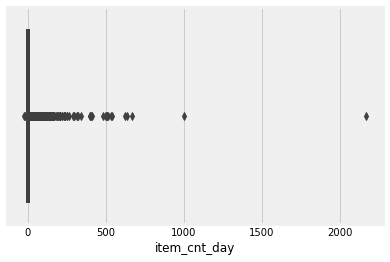

In [15]:
sales_copy = sales_train.copy()
sns.boxplot(sales_train.item_cnt_day)

In [16]:
sorted(sales_train.item_cnt_day,reverse=True)[0:5]

[2169.0, 1000.0, 669.0, 637.0, 624.0]

In [17]:
sales_train.loc[sales_train.item_cnt_day.idxmax()]

date              28.10.2015
date_block_num            33
shop_id                   12
item_id                11373
item_price          0.908714
item_cnt_day            2169
Name: 2909818, dtype: object

In [18]:
# Use median value for outliers
median = sales_train[(sales_train.shop_id==12)&(
    sales_train.item_id==11373)&(sales_train.date_block_num==33)&(
    sales_train.item_cnt_day<2000)].item_cnt_day.median()
sales_train.loc[sales_train.item_cnt_day > 2000, 'item_cnt_day'] = round(median)

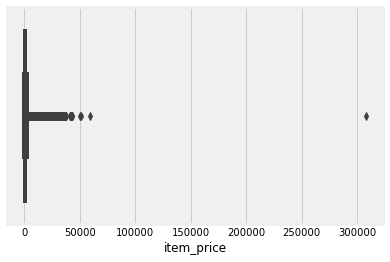

In [19]:
sns.boxplot(sales_train.item_price)

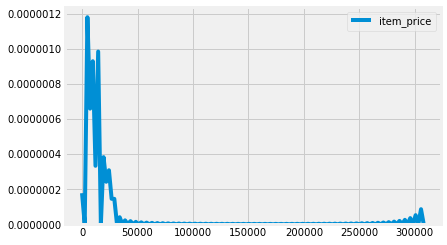

In [20]:
sns.kdeplot(sales_train.item_price)

In [21]:
tmp = sorted(sales_train.item_price.unique())
print(tmp[:5])
print(tmp[::-1][:5])

[-1.0, 0.07, 0.0875, 0.09, 0.1]
[307980.0, 59200.0, 50999.0, 49782.0, 42990.0]


In [22]:
sales_train.loc[sales_train.item_price.idxmax()]

date              13.12.2013
date_block_num            11
shop_id                   12
item_id                 6066
item_price            307980
item_cnt_day               1
Name: 1163158, dtype: object

In [23]:
# only one record for this item_id
sales_train[sales_train.item_id==6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


In [24]:
#median = sales_train[(sales_train.shop_id==12)&(sales_train.date_block_num==11)&(
#    sales_train.item_price>0)&(sales_train.item_price<60000)].item_price.median()
sales_train.loc[sales_train.item_id==6066, 'item_price'] /= 10

In [25]:
sales_train.loc[sales_train.item_price.idxmin()]

date              15.05.2013
date_block_num             4
shop_id                   32
item_id                 2973
item_price                -1
item_cnt_day               1
Name: 484683, dtype: object

In [26]:
median = sales_train[(sales_train.shop_id==32)&(
    sales_train.item_id==2973)&(sales_train.date_block_num==4)&(
    sales_train.item_price>0)].item_price.median()
sales_train.loc[sales_train.item_price<0, 'item_price'] = median

In [27]:
sales_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

Let's deal with duplicated shop names

In [28]:
print(shops.loc[0].shop_name)
print(shops.loc[57].shop_name)
print(shops.loc[1].shop_name)
print(shops.loc[58].shop_name)
print(shops.loc[10].shop_name)
print(shops.loc[11].shop_name)

!Якутск Орджоникидзе, 56 фран
Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран
Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м?
Жуковский ул. Чкалова 39м²


In [29]:
# Якутск Орджоникидзе, 56
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_train.loc[sales_train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [30]:
# Check for duplicates
cols = ['date','date_block_num','shop_id','item_id','item_cnt_day']
print(sales_train.duplicated(subset=cols).value_counts())
sales_train.drop_duplicates(subset=cols, inplace=True)

False    2935825
True          24
dtype: int64


## 2.2. Extracting categorical features from item names<a name="Extracting22"></a>

In [31]:
# save a copy for text feature processing
shops_copy = shops.copy()
item_categories_copy = item_categories.copy()
items_copy = items.copy()

In [32]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

In [33]:
shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [34]:
item_categories['split'] = item_categories['item_category_name'].str.split('-')
item_categories['type'] = item_categories['split'].map(lambda x: x[0].strip())
item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])
item_categories['subtype'] = item_categories['split'].map(
    lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])
item_categories = item_categories[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [35]:
item_categories.head()

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [36]:
item_categories.nunique()

item_category_id    84
type_code           20
subtype_code        65
dtype: int64

In [37]:
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


## 2.3. ID values of Train and test data<a name="Making23"></a>


In [38]:
# test1 = test.copy()
# test1['key'] = test1['shop_id'].astype(str) + '_' + test1['item_id'].astype(str)
# print(test1['key'].nunique() == len(test1))
# del test1
print(test.duplicated(subset=['shop_id','item_id']).value_counts().values == len(test))

[ True]


In [39]:
print('number of item_id in test set', test.item_id.nunique())
print('number of item_id in train set', sales_train.item_id.nunique())
diff = test.item_id.nunique() - sales_train.item_id.nunique()
print('number of difference between two above', diff)
diff = set(test.item_id) - set(sales_train.item_id)
print('number of item_id include in test but not in sales_train', len(diff))
diff =   set(sales_train.item_id) - set(test.item_id)
print('number of item_id include in sales_train but not in test', len(diff))

number of item_id in test set 5100
number of item_id in train set 21807
number of difference between two above -16707
number of item_id include in test but not in sales_train 363
number of item_id include in sales_train but not in test 17070


In [40]:
print('number of shop_id in test set', test.shop_id.nunique())
print('number of shop_id in train set', sales_train.shop_id.nunique())
diff = test.shop_id.nunique() - sales_train.shop_id.nunique()
print('number of difference between two above', diff)
diff = set(test.shop_id) - set(sales_train.shop_id)
print('number of shop_id include in test but not in sales_train', len(diff))
diff =   set(sales_train.shop_id) - set(test.shop_id)
print('number of shop_id include in sales_train but not in test', len(diff))

number of shop_id in test set 42
number of shop_id in train set 57
number of difference between two above -15
number of shop_id include in test but not in sales_train 0
number of shop_id include in sales_train but not in test 15


#### Note
The difference of unique number of item_id between test and sales_train data set indicates that there are 363 item_ids which are not included in sales_train data set. We need to add these item_ids into our train data set so that train data will be similar to test data.   
Tha main idea is to calculate monthly sales and extend it with zero sales for each unique pair within the month. 

In [41]:
cols = ['shop_id','item_id']
unique_key = pd.concat([test[cols], sales_train[cols]], ignore_index=True, sort=False)
print('Number of unique item_id ',unique_key.item_id.nunique())
print('Number of unique shop_id ',unique_key.shop_id.nunique())
unique_key.drop_duplicates(subset=cols, inplace=True)
print('Number of unique shop_id item_id pairs ',unique_key.shape[0])

Number of unique item_id  22170
Number of unique shop_id  57
Number of unique shop_id item_id pairs  521638


In [42]:
if 1: # delete shop_id which not include in test
    unique_key = unique_key.merge(test[['shop_id']].drop_duplicates(), how = 'inner')
    print('Number of unique shop_id item_id pairs ',unique_key.shape[0])

Number of unique shop_id item_id pairs  441092


In [43]:
if 1: # delete item_id which not include in test
    unique_key = unique_key.merge(test[['item_id']].drop_duplicates(), how = 'inner')
    print('Number of unique shop_id item_id pairs ',unique_key.shape[0])

Number of unique shop_id item_id pairs  214200


In [44]:
test.shape

(214200, 3)

In [45]:
unique_key.nunique()

shop_id      42
item_id    5100
dtype: int64

In [51]:
test1 = test.copy()
test1['date_block_num'] = 34
cols = ['date_block_num','shop_id','item_id']

matrix = pd.DataFrame()
# from itertools import product
# grid = []
# sales1 = sales_train.merge(test[['shop_id']].drop_duplicates(), how = 'inner')
for i in tqdm(range(0,34)):
    unique_key['date_block_num'] = i
    matrix = pd.concat([matrix,unique_key])
    
#     sales2 = sales1[sales1.date_block_num == i]
    
#     cur_shops = sales2['shop_id'].unique()

#     cur_items = sales2['item_id'].unique()

#     grid.append(np.array(list(product(*[cur_shops, cur_items, [i]])),dtype='int32'))
# index_cols = ['shop_id', 'item_id', 'date_block_num']
# matrix = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

matrix = pd.concat([matrix,test1[cols]], ignore_index=True, sort=False)
del test1, unique_key

100%|██████████| 34/34 [00:03<00:00,  5.01it/s]


In [52]:
matrix.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

# check id order
matrix_tmp = matrix.copy()
for m in range(0,35):
    matrix_tmp.loc[matrix.date_block_num==m,['shop_id','item_id']] -= test[['shop_id','item_id']]
print(matrix_tmp.loc[:,['shop_id','item_id']].sum())
del matrix_tmp

shop_id    0.0
item_id    0.0
dtype: float64


In [53]:
print(matrix.shape, matrix[matrix.date_block_num<34].shape)
matrix.tail()

(7497000, 3) (7282800, 3)


,shop_id,item_id,date_block_num
7432375,59,22162,34
7431599,59,22163,34
7432042,59,22164,34
7435128,59,22166,34
7431177,59,22167,34


## 2.4. Text features with TF-IDF<a name="Text24"></a>

In [54]:
nb_features = 25
tfidf = text.TfidfVectorizer(max_features=nb_features)
items_copy['item_name_len'] = items_copy['item_name'].map(len).astype(np.int8)  # Name lenth
items_copy['item_name_wc'] = items_copy['item_name'].map(
    lambda x: len(str(x).split(' '))).astype(np.int8)  # Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(items_copy['item_name']).toarray())
cols = txtFeatures.columns
for i in range(nb_features):
    items_copy['item_name_tfidf_' + str(i)] = txtFeatures[cols[i]].astype(np.float16)
items_copy.head()

,item_name,item_id,item_category_id,item_name_len,item_name_wc,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,41,14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,68,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.637695,0.0,0.0,0.0,0.0,0.442627,0.0,0.0,0.0,0.403809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.483887
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,45,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,47,26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,***КОРОБКА (СТЕКЛО) D,4,40,43,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [55]:
items_copy.columns

Index(['item_name', 'item_id', 'item_category_id', 'item_name_len',
       'item_name_wc', 'item_name_tfidf_0', 'item_name_tfidf_1',
       'item_name_tfidf_2', 'item_name_tfidf_3', 'item_name_tfidf_4',
       'item_name_tfidf_5', 'item_name_tfidf_6', 'item_name_tfidf_7',
       'item_name_tfidf_8', 'item_name_tfidf_9', 'item_name_tfidf_10',
       'item_name_tfidf_11', 'item_name_tfidf_12', 'item_name_tfidf_13',
       'item_name_tfidf_14', 'item_name_tfidf_15', 'item_name_tfidf_16',
       'item_name_tfidf_17', 'item_name_tfidf_18', 'item_name_tfidf_19',
       'item_name_tfidf_20', 'item_name_tfidf_21', 'item_name_tfidf_22',
       'item_name_tfidf_23', 'item_name_tfidf_24'],
      dtype='object')

In [56]:
tfidf = text.TfidfVectorizer(max_features=nb_features)
shops_copy['shop_name_len'] = shops_copy['shop_name'].map(len).astype(np.int8)  # Name lenth
shops_copy['shop_name_wc'] = shops_copy['shop_name'].map(
    lambda x: len(str(x).split(' '))).astype(np.int8)  # Word Count
txtFeatures = pd.DataFrame(tfidf.fit_transform(shops_copy['shop_name']).toarray())
cols = txtFeatures.columns
for i in range(nb_features):
    shops_copy['shop_name_tfidf_' + str(i)] = txtFeatures[cols[i]].astype(np.float16)
shops_copy.head()

,shop_name,shop_id,shop_name_len,shop_name_wc,shop_name_tfidf_0,shop_name_tfidf_1,shop_name_tfidf_2,shop_name_tfidf_3,shop_name_tfidf_4,shop_name_tfidf_5,shop_name_tfidf_6,shop_name_tfidf_7,shop_name_tfidf_8,shop_name_tfidf_9,shop_name_tfidf_10,shop_name_tfidf_11,shop_name_tfidf_12,shop_name_tfidf_13,shop_name_tfidf_14,shop_name_tfidf_15,shop_name_tfidf_16,shop_name_tfidf_17,shop_name_tfidf_18,shop_name_tfidf_19,shop_name_tfidf_20,shop_name_tfidf_21,shop_name_tfidf_22,shop_name_tfidf_23,shop_name_tfidf_24
0,"!Якутск Орджоникидзе, 56 фран",0,29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,1.000000
1,"!Якутск ТЦ ""Центральный"" фран",1,29,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.322754,0.0,0.689453,0.648438
2,"Адыгея ТЦ ""Мега""",2,16,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866699,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.498535,0.0,0.000000,0.000000
3,"Балашиха ТРК ""Октябрь-Киномир""",3,30,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000
4,"Волжский ТЦ ""Волга Молл""",4,24,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.905762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.424072,0.0,0.000000,0.000000


In [57]:
shops_copy.columns

Index(['shop_name', 'shop_id', 'shop_name_len', 'shop_name_wc',
       'shop_name_tfidf_0', 'shop_name_tfidf_1', 'shop_name_tfidf_2',
       'shop_name_tfidf_3', 'shop_name_tfidf_4', 'shop_name_tfidf_5',
       'shop_name_tfidf_6', 'shop_name_tfidf_7', 'shop_name_tfidf_8',
       'shop_name_tfidf_9', 'shop_name_tfidf_10', 'shop_name_tfidf_11',
       'shop_name_tfidf_12', 'shop_name_tfidf_13', 'shop_name_tfidf_14',
       'shop_name_tfidf_15', 'shop_name_tfidf_16', 'shop_name_tfidf_17',
       'shop_name_tfidf_18', 'shop_name_tfidf_19', 'shop_name_tfidf_20',
       'shop_name_tfidf_21', 'shop_name_tfidf_22', 'shop_name_tfidf_23',
       'shop_name_tfidf_24'],
      dtype='object')

## 2.5. Feature matrix<a name="Feature27"></a>

#### Group month values

In [58]:
sales_train['item_cnt_day'] = sales_train['item_cnt_day'].clip(0,20).astype(np.int)
cols = ['date_block_num','shop_id','item_id']
group = sales_train.groupby(cols).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group['item_cnt_month'] = group['item_cnt_month'].clip(0,20).astype(np.int)
group.reset_index(inplace=True)

all_data = pd.merge(matrix, group, on=cols, how='left', suffixes=(False, False))

all_data['item_cnt_month'] = all_data['item_cnt_month'].fillna(0).astype(np.int)

# Sanity check
print(sales_train['item_cnt_day'].sum(), all_data['item_cnt_month'].sum(), group['item_cnt_month'].sum())

del group, matrix

3582096 1373797 3261287


In [72]:
all_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,month,days_of_month,year
0,2,30,0,0,1,31,2
1,2,31,0,0,1,31,2
2,2,32,0,0,1,31,2
3,2,33,0,1,1,31,2
4,2,38,0,0,1,31,2


In [74]:
all_data['month'] = all_data['date_block_num'] % 12 
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
all_data['days_of_month'] = all_data['month'].map(days).astype(np.int8)
all_data['month'] = all_data['month'] + 1
all_data['year'] = all_data['date_block_num'].apply(lambda x:int((34-x)/12))

all_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,month,days_of_month,year
0,2,30,0,0,1,31,2
1,2,31,0,0,1,31,2
2,2,32,0,0,1,31,2
3,2,33,0,1,1,31,2
4,2,38,0,0,1,31,2


In [75]:
all_data.dtypes

shop_id           int64
item_id           int64
date_block_num    int64
item_cnt_month    int64
month             int64
days_of_month      int8
year              int64
dtype: object

#### Merge with shops, items and item_categories

In [76]:
all_data = pd.merge(all_data, shops, on=['shop_id'], how='left')
all_data = pd.merge(all_data, items, on=['item_id'], how='left')
all_data = pd.merge(all_data, item_categories, on=['item_category_id'], how='left')

In [77]:
all_data.shape

(7497000, 11)

In [78]:
all_data = pd.merge(all_data, items_copy.drop('item_category_id',axis=1), how='left', on='item_id')
all_data = pd.merge(all_data, shops_copy, how='left', on='shop_id')
del shops, items, item_categories, items_copy, shops_copy
all_data.shape

(7497000, 67)

In [79]:
def downcast_dtypes(df):

    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype in ["int64", "int32"]]

    df[float_cols] = df[float_cols].astype(np.float32)
    #df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols]   = df[int_cols].astype(np.int16)
    #df[int_cols]   = df[int_cols].astype(np.int8)

    return df

In [80]:
all_data.drop(['item_name', 'item_name_len', 'item_name_wc', 
         'shop_name', 'shop_name_len', 'shop_name_wc'], axis=1, inplace=True)
all_data = downcast_dtypes(all_data)

print(all_data.shape)

(7497000, 61)


In [81]:
all_data.columns.values

array(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'month',
       'days_of_month', 'year', 'city_code', 'item_category_id',
       'type_code', 'subtype_code', 'item_name_tfidf_0',
       'item_name_tfidf_1', 'item_name_tfidf_2', 'item_name_tfidf_3',
       'item_name_tfidf_4', 'item_name_tfidf_5', 'item_name_tfidf_6',
       'item_name_tfidf_7', 'item_name_tfidf_8', 'item_name_tfidf_9',
       'item_name_tfidf_10', 'item_name_tfidf_11', 'item_name_tfidf_12',
       'item_name_tfidf_13', 'item_name_tfidf_14', 'item_name_tfidf_15',
       'item_name_tfidf_16', 'item_name_tfidf_17', 'item_name_tfidf_18',
       'item_name_tfidf_19', 'item_name_tfidf_20', 'item_name_tfidf_21',
       'item_name_tfidf_22', 'item_name_tfidf_23', 'item_name_tfidf_24',
       'shop_name_tfidf_0', 'shop_name_tfidf_1', 'shop_name_tfidf_2',
       'shop_name_tfidf_3', 'shop_name_tfidf_4', 'shop_name_tfidf_5',
       'shop_name_tfidf_6', 'shop_name_tfidf_7', 'shop_name_tfidf_8',
       'shop_name_t

In [82]:
missing = all_data.isnull().sum()
missing[missing > 0]

Series([], dtype: int64)

In [63]:
#all_data.fillna(0, inplace=True)

In [83]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [84]:
# save temp file
outfile = open('test','wb')
pickle.dump(test,outfile)
outfile.close()

In [85]:
# save temp file
outfile = open('all_data2','wb')
pickle.dump(all_data,outfile)
outfile.close()

In [67]:
#!tar -czvf all_data2.tar.gz  'all_data2'

infile = open('all_data2','rb')
all_data = pickle.load(infile)
infile.close()

# Part 3/8: Exploratory data analysis<a name="Exploratory3"></a>


The **target variable** to be predicted is the `item_cnt_month` (number of items sold).

sales_train['date'] = pd.to_datetime(sales_train['date'], format="%d.%m.%Y")

sales_train.groupby('date').agg(
    {'item_cnt_day': 'sum'}).plot(kind='area',
    figsize=(12,5), title="The number of items sold per day", lw=1.0, color='green')
sales_train.groupby('date_block_num').agg(
    {'item_cnt_day': 'sum'}).plot(kind='bar',
    figsize=(12,5), title="The number of items sold per month",lw=3.0, color='blue')
plt.show()

fig, ax = plt.subplots(figsize=(10.2,5))
ax = sns.kdeplot(all_data['item_cnt_month'].values, shade=True, color="red", ax=ax)
ax.set_xlabel('item_cnt_month')
ax.set_ylabel('Density')
ax.set_title('Target KDE distribution')
plt.tight_layout()
plt.show()

#### Note
There are sale peaks in every November.

## 3.2. Quick Baseline<a name="Quick32"></a>

In [86]:
dates = all_data['date_block_num']

In [87]:
Target = 'item_cnt_month'
selected_features = all_data.columns.tolist()
selected_features.remove(Target)
selected_features.remove('date_block_num')
all_data[selected_features].nunique()

shop_id                 42
item_id               5100
month                   12
days_of_month            3
year                     3
city_code               28
item_category_id        62
type_code               16
subtype_code            49
item_name_tfidf_0       39
item_name_tfidf_1       30
item_name_tfidf_2       14
item_name_tfidf_3       15
item_name_tfidf_4       34
item_name_tfidf_5       20
item_name_tfidf_6       24
item_name_tfidf_7       53
item_name_tfidf_8       41
item_name_tfidf_9       11
item_name_tfidf_10      25
item_name_tfidf_11      71
item_name_tfidf_12      75
item_name_tfidf_13      25
item_name_tfidf_14      70
item_name_tfidf_15      51
item_name_tfidf_16     119
item_name_tfidf_17      46
item_name_tfidf_18      26
item_name_tfidf_19      36
item_name_tfidf_20       5
item_name_tfidf_21      76
item_name_tfidf_22       9
item_name_tfidf_23      15
item_name_tfidf_24      49
shop_name_tfidf_0        3
shop_name_tfidf_1        2
shop_name_tfidf_2        3
s

In [88]:
def standard_all_data(all_data):
    
    df = all_data.nunique()
    df = df[df > 2]
    features_to_scale = df.index.tolist()
    features_to_scale.remove('item_cnt_month')

    #X_train = all_data[dates < 34]
    #X_test = all_data[dates == 34]

    scaler = StandardScaler()

    all_data.loc[dates < 34,features_to_scale] = scaler.fit_transform(all_data[dates < 34][features_to_scale])
    all_data.loc[dates == 34,features_to_scale] = scaler.transform(all_data[dates == 34][features_to_scale])
    
    #all_data = pd.concat([X_train, X_test], axis = 0)
    
    #all_data = downcast_dtypes(all_data)

    return all_data

In [89]:
all_data_tmp = all_data.copy()
all_data_tmp = standard_all_data(all_data_tmp)

X_train = all_data_tmp[dates<33][selected_features]
Y_train = all_data_tmp[dates<33][Target]

X_valid = all_data_tmp[dates==33][selected_features]
Y_valid = all_data_tmp[dates==33][Target]

X_test =  all_data_tmp[dates==34][selected_features]



print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)

(7068600, 59)
(7068600,)
(214200, 59)
(214200,)
(214200, 59)


In [90]:
model_linreg = LinearRegression(fit_intercept=True)
model_linreg.fit(X_train, Y_train)
print('Valid error: ',np.sqrt(mean_squared_error(Y_valid, model_linreg.predict(X_valid))))
preds = model_linreg.predict(X_test).clip(0,20)
print('preds mean',preds.mean())

Valid error:  1.0721808294374517
preds mean 0.29573819961760944


In [91]:
model_ridge = Ridge()
model_ridge.fit(X_train, Y_train)
print('Valid error: ',np.sqrt(mean_squared_error(Y_valid, model_ridge.predict(X_valid))))
preds = model_ridge.predict(X_test).clip(0,20)
print('preds mean',preds.mean())

Valid error:  1.0721808433646145
preds mean 0.29573817708662065


In [92]:
model_lasso = Lasso(alpha=10.0, fit_intercept=True, max_iter=1000)
model_lasso.fit(X_train, Y_train)
print('Valid error: ',np.sqrt(mean_squared_error(Y_valid, model_lasso.predict(X_valid))))
preds = model_lasso.predict(X_test).clip(0,20)
print('preds mean',preds.mean())

Valid error:  1.0930244910155278
preds mean 0.186589989531166


In [93]:
del all_data_tmp

# Part 4/8: Advanced Feature Engineering<a name="Advanced4"></a>

## 4.1. Matrix factorization of TFIDF processed features<a name="Matrix42"></a>

To reduce the dimensionality of the TFIDF-processed features (from 50 dimensions to 10) and extract nonlinear relationships between the text features with **Non-Negative Matrix Factorization (NMF)**:

In [94]:
tfidf_features = ['item_name_tfidf_0', 'item_name_tfidf_1', 'item_name_tfidf_2',
                  'item_name_tfidf_3', 'item_name_tfidf_4', 'item_name_tfidf_5',
                  'item_name_tfidf_6', 'item_name_tfidf_7', 'item_name_tfidf_8',
                  'item_name_tfidf_9', 'item_name_tfidf_10', 'item_name_tfidf_11',
                  'item_name_tfidf_12', 'item_name_tfidf_13', 'item_name_tfidf_14',
                  'item_name_tfidf_15', 'item_name_tfidf_16', 'item_name_tfidf_17',
                  'item_name_tfidf_18', 'item_name_tfidf_19', 'item_name_tfidf_20',
                  'item_name_tfidf_21', 'item_name_tfidf_22', 'item_name_tfidf_23',
                  'item_name_tfidf_24', 'shop_name_tfidf_0', 'shop_name_tfidf_1',
                  'shop_name_tfidf_2', 'shop_name_tfidf_3', 'shop_name_tfidf_4',
                  'shop_name_tfidf_5', 'shop_name_tfidf_6', 'shop_name_tfidf_7',
                  'shop_name_tfidf_8', 'shop_name_tfidf_9', 'shop_name_tfidf_10',
                  'shop_name_tfidf_11', 'shop_name_tfidf_12', 'shop_name_tfidf_13',
                  'shop_name_tfidf_14', 'shop_name_tfidf_15', 'shop_name_tfidf_16',
                  'shop_name_tfidf_17', 'shop_name_tfidf_18', 'shop_name_tfidf_19',
                  'shop_name_tfidf_20', 'shop_name_tfidf_21', 'shop_name_tfidf_22',
                  'shop_name_tfidf_23', 'shop_name_tfidf_24']

Xtrain = all_data[all_data['date_block_num']<34][tfidf_features]
Xtest = all_data[all_data['date_block_num']==34][tfidf_features]
print(Xtrain.shape, Xtest.shape)
#X_all = pd.concat([Xtrain, Xtest], ignore_index=True)
#X_all.shape

(7282800, 50) (214200, 50)


In [95]:
nmf = NMF(n_components=10, 
          init=None, solver='cd', 
          beta_loss='frobenius', 
          tol=0.0001, 
          max_iter=200)
nmf.fit(all_data[tfidf_features]);

In [96]:
Xtrain = nmf.transform(Xtrain)
Xtest = nmf.transform(Xtest)

In [97]:
print(Xtrain.shape, Xtest.shape)

(7282800, 10) (214200, 10)


In [98]:
all_data.drop(tfidf_features, axis=1, inplace=True)

In [99]:
tfidf_reduced_df = pd.concat([pd.DataFrame(Xtrain), pd.DataFrame(Xtest)], axis=0)
tfidf_reduced_df.columns = ['tfidf_interaction_1', 'tfidf_interaction_2', 'tfidf_interaction_3',
                            'tfidf_interaction_4', 'tfidf_interaction_5', 'tfidf_interaction_6',
                            'tfidf_interaction_7', 'tfidf_interaction_8', 'tfidf_interaction_9',
                            'tfidf_interaction_10']
print(tfidf_reduced_df.shape)
tfidf_reduced_df.head()

(7497000, 10)


,tfidf_interaction_1,tfidf_interaction_2,tfidf_interaction_3,tfidf_interaction_4,tfidf_interaction_5,tfidf_interaction_6,tfidf_interaction_7,tfidf_interaction_8,tfidf_interaction_9,tfidf_interaction_10
0,0.003910,0.0,0.0,0.0,0.000000,0.029964,0.0,0.0,0.0,0.0
1,0.003729,0.0,0.0,0.0,0.032719,0.029942,0.0,0.0,0.0,0.0
2,0.003910,0.0,0.0,0.0,0.000000,0.029964,0.0,0.0,0.0,0.0
3,0.003729,0.0,0.0,0.0,0.032719,0.029942,0.0,0.0,0.0,0.0
4,0.003910,0.0,0.0,0.0,0.000000,0.029964,0.0,0.0,0.0,0.0


In [100]:
for col in tfidf_reduced_df.columns:
    print(col)
    all_data[col] = tfidf_reduced_df[col].values
     
del tfidf_reduced_df

tfidf_interaction_1
tfidf_interaction_2
tfidf_interaction_3
tfidf_interaction_4
tfidf_interaction_5
tfidf_interaction_6
tfidf_interaction_7
tfidf_interaction_8
tfidf_interaction_9
tfidf_interaction_10


In [101]:
Target = 'item_cnt_month'
selected_features = all_data.columns.tolist()
selected_features.remove(Target)
selected_features.remove('date_block_num')

In [102]:
all_data_tmp = all_data.copy()
all_data_tmp = standard_all_data(all_data_tmp)

X_train = all_data_tmp[dates<33][selected_features]
Y_train = all_data_tmp[dates<33][Target]

X_valid = all_data_tmp[dates==33][selected_features]
Y_valid = all_data_tmp[dates==33][Target]

X_test =  all_data_tmp[dates==34][selected_features]



print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)

(7068600, 19)
(7068600,)
(214200, 19)
(214200,)
(214200, 19)


In [103]:
model_linreg = LinearRegression(fit_intercept=True)
model_linreg.fit(X_train, Y_train)
print('Valid error: ',np.sqrt(mean_squared_error(Y_valid, model_linreg.predict(X_valid))))
preds = model_linreg.predict(X_test).clip(0,20)
print('preds mean',preds.mean())

Valid error:  1.0829878880762345
preds mean 0.2944902178390091


In [104]:
model_ridge = Ridge()
model_ridge.fit(X_train, Y_train)
print('Valid error: ',np.sqrt(mean_squared_error(Y_valid, model_ridge.predict(X_valid))))
preds = model_ridge.predict(X_test).clip(0,20)
print('preds mean',preds.mean())

Valid error:  1.0829878899119134
preds mean 0.2944902008211132


In [105]:
model_lasso = Lasso(alpha=10.0, fit_intercept=True, max_iter=1000)
model_lasso.fit(X_train, Y_train)
print('Valid error: ',np.sqrt(mean_squared_error(Y_valid, model_lasso.predict(X_valid))))
preds = model_lasso.predict(X_test).clip(0,20)
print('preds mean',preds.mean())

Valid error:  1.0930244910155278
preds mean 0.186589989531166


In [ ]:
# save temp file
outfile = open('all_data40','wb')
pickle.dump(all_data,outfile)
outfile.close()
all_data.columns

In [107]:
del all_data_tmp

In [46]:
infile = open('all_data40','rb')
all_data = pickle.load(infile)
infile.close()

## 4.2. Mean encodings on categorical features (not working,overfitting)<a name="Mean41"></a>

Mean encodings look to map a high cardinality categorical feature into a 1D array (instead of high numbers of them had we used one-hot encoding) based on how often the target variable appears on average in the categorical feature. It is a convenient approach since it also has a clever way of imputing missing values among categorical variables.

## 4.3. Last sales month<a name="Last"></a>

In [47]:
group = sales_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg(
    {'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group['item_cnt_month'] = group['item_cnt_month'].clip(0,20)
group.reset_index(inplace=True)

for col in tqdm([['item_id'],['shop_id', 'item_id']]):
    last_sale = pd.DataFrame()
    for month in range(12,35):    
        last_month = group.loc[(group['date_block_num']<month)&(
            group['item_cnt_month']>0)].groupby(col).agg(
            {'date_block_num':['max','min']})
        feature_name = ['last_sale_' + ''.join(col),'first_sale_' + ''.join(col)]
        last_month.columns = feature_name
        last_month.reset_index(inplace=True)
        df = pd.DataFrame()
        df[col+feature_name] = last_month[col+feature_name]
        df[feature_name] = month - df[feature_name]
        df['date_block_num'] = month
        
#         df = pd.DataFrame({'date_block_num':np.ones([last_month.shape[0],])*month,
#                            col[0]: last_month.index.values,
#                            'last_sale' + '_'.join(col): last_month.values})
        last_sale = last_sale.append(df)
#     last_sale['date_block_num'] = last_sale['date_block_num'].astype(np.int8)

    all_data = all_data.merge(last_sale, on=['date_block_num']+col, 
                              how='left',suffixes=(False, False))
    all_data[feature_name] = all_data[feature_name].fillna(100)

100%|██████████| 2/2 [00:40<00:00, 16.25s/it]


In [48]:
all_data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'item_cnt_month', 'month',
       'days_of_month', 'year', 'city_code', 'item_category_id', 'type_code',
       'subtype_code', 'tfidf_interaction_1', 'tfidf_interaction_2',
       'tfidf_interaction_3', 'tfidf_interaction_4', 'tfidf_interaction_5',
       'tfidf_interaction_6', 'tfidf_interaction_7', 'tfidf_interaction_8',
       'tfidf_interaction_9', 'tfidf_interaction_10', 'last_sale_item_id',
       'first_sale_item_id', 'last_sale_shop_iditem_id',
       'first_sale_shop_iditem_id'],
      dtype='object')

In [49]:
all_data['first_sale_shop_iditem_id'].min()

1.0

## 4.4. Creating lag features<a name="lag"></a>

In [50]:
Target = 'item_cnt_month'
index_cols = ['date_block_num','shop_id', 'item_id',
              'item_category_id','type_code','subtype_code','city_code','days_of_month'] 
train = all_data[all_data['date_block_num']<34][index_cols + [Target]].copy()
train.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'type_code',
       'subtype_code', 'city_code', 'days_of_month', 'item_cnt_month'],
      dtype='object')

In [51]:
group_cols = ['date_block_num', 'shop_id', 'item_id']
group = sales_train.groupby(group_cols).agg(
    {'item_price':['mean']})
group.columns = ['price_shop_item_mean']
group.reset_index(inplace=True)
train = pd.merge(train, group, on=group_cols, how='left', suffixes=(False, False))

group_cols = ['item_id', 'date_block_num']
group = sales_train.groupby(group_cols).agg(
    {'item_price':['mean']})
group.columns = ['price_item_mean']
group.reset_index(inplace=True)
train = pd.merge(train, group, on=group_cols, how='left', suffixes=(False, False))

group_cols = ['item_id', 'date_block_num']
group = train.groupby(group_cols).agg({'item_cnt_month':'mean'})
group.columns = ['item_cnt_month_by_item_id_mean']
group.reset_index(inplace=True)
train = pd.merge(train, group, on=group_cols, how='left', suffixes=(False, False))

cols_group = [
['date_block_num', 'shop_id'],
['date_block_num', 'item_category_id'],
['date_block_num', 'shop_id', 'item_category_id'],
['date_block_num', 'shop_id', 'type_code'],
['date_block_num', 'shop_id', 'subtype_code'],
['date_block_num', 'city_code'],
['date_block_num', 'item_id', 'city_code'],
['date_block_num', 'type_code'],
['date_block_num', 'subtype_code'],
]

for cols in tqdm(cols_group):
    group = train.groupby(cols).agg({'item_cnt_month':'mean'})
    group.columns = ['item_cnt_month_by_' + '_'.join(cols)]
    group.reset_index(inplace=True)
    train = pd.merge(train, group, on=cols, how='left', suffixes=(False, False))

lag_cols = ['item_cnt_month',
            'item_cnt_month_by_item_id_mean',
            'price_shop_item_mean',
            'price_item_mean',
           ]
lag_cols += ['item_cnt_month_by_' + '_'.join(cols) for cols in cols_group]


100%|██████████| 9/9 [00:32<00:00,  4.15s/it]


In [52]:
item_cnt_list = [e for e in lag_cols if e not in ['price_shop_item_mean','price_item_mean']]
for col in tqdm(item_cnt_list):
    train[col] /= train['days_of_month']

100%|██████████| 11/11 [00:00<00:00, 12.97it/s]


In [53]:
train.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_category_id', 'type_code',
       'subtype_code', 'city_code', 'days_of_month', 'item_cnt_month',
       'price_shop_item_mean', 'price_item_mean',
       'item_cnt_month_by_item_id_mean',
       'item_cnt_month_by_date_block_num_shop_id',
       'item_cnt_month_by_date_block_num_item_category_id',
       'item_cnt_month_by_date_block_num_shop_id_item_category_id',
       'item_cnt_month_by_date_block_num_shop_id_type_code',
       'item_cnt_month_by_date_block_num_shop_id_subtype_code',
       'item_cnt_month_by_date_block_num_city_code',
       'item_cnt_month_by_date_block_num_item_id_city_code',
       'item_cnt_month_by_date_block_num_type_code',
       'item_cnt_month_by_date_block_num_subtype_code'],
      dtype='object')

In [54]:
missing = train.isnull().sum()
missing[missing > 0]

price_shop_item_mean    6681051
price_item_mean         4358256
dtype: int64

In [55]:
lag_cols

['item_cnt_month',
 'item_cnt_month_by_item_id_mean',
 'price_shop_item_mean',
 'price_item_mean',
 'item_cnt_month_by_date_block_num_shop_id',
 'item_cnt_month_by_date_block_num_item_category_id',
 'item_cnt_month_by_date_block_num_shop_id_item_category_id',
 'item_cnt_month_by_date_block_num_shop_id_type_code',
 'item_cnt_month_by_date_block_num_shop_id_subtype_code',
 'item_cnt_month_by_date_block_num_city_code',
 'item_cnt_month_by_date_block_num_item_id_city_code',
 'item_cnt_month_by_date_block_num_type_code',
 'item_cnt_month_by_date_block_num_subtype_code']

In [56]:
item_cnt_list

['item_cnt_month',
 'item_cnt_month_by_item_id_mean',
 'item_cnt_month_by_date_block_num_shop_id',
 'item_cnt_month_by_date_block_num_item_category_id',
 'item_cnt_month_by_date_block_num_shop_id_item_category_id',
 'item_cnt_month_by_date_block_num_shop_id_type_code',
 'item_cnt_month_by_date_block_num_shop_id_subtype_code',
 'item_cnt_month_by_date_block_num_city_code',
 'item_cnt_month_by_date_block_num_item_id_city_code',
 'item_cnt_month_by_date_block_num_type_code',
 'item_cnt_month_by_date_block_num_subtype_code']

In [57]:
# 2.2 Creating item/shop pair lags lag-based features ----------------------------

last_lag_names = []

lag_month = [1,2,3,4,5,6,7,8,9,10,11,12]
all_data = all_data[all_data.date_block_num >= max(lag_month)].copy()
i = 0
eps = 1e-5
index_cols = ['date_block_num','shop_id', 'item_id']
train_shift = train[index_cols + lag_cols].copy()
for m in tqdm(lag_month):

    #train_shift = train[index_cols + cols_to_rename].copy()
    train_shift.columns = index_cols + lag_cols

    train_shift['date_block_num'] = train['date_block_num'] + m

    lag_names = [col + '_lag_' + str(m) for col in lag_cols]

    train_shift.columns = index_cols + lag_names

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left', suffixes=(False, False))
    
    item_cnt_lag_list = [col + '_lag_' + str(m) for col in item_cnt_list]
    for col in item_cnt_lag_list:
        all_data[col] *= all_data['days_of_month']

    feature_name = ['is_sold_shopitem_month_' + str(m),
                    'is_sold_item_month_' + str(m),
                    'is_sales_down_shopitem_month_' + str(m),
                    'is_sales_up_shopitem_month_' + str(m), 
                    'is_sales_down_item_month_' + str(m),
                    'is_sales_up_item_month_' + str(m), 
                    'is_price_down_shopitem_month_' + str(m),
                    'is_price_up_shopitem_month_' + str(m), 
                    'is_price_down_item_month_' + str(m),
                    'is_price_up_item_month_' + str(m)
                   ]
        
    all_data.loc[:,lag_names[:2]].fillna(0, inplace=True)
    
#     condition = all_data[lag_names[0]] != 0
#     all_data.loc[condition,feature_name[0]] = 1
#     condition = all_data[lag_names[1]] != 0
#     all_data.loc[condition,feature_name[1]] = 1
    
    if i > 0:
        # sales delta
        all_data['sales_shopitem_delta'+str(m)] = \
            (all_data[lag_names[0]] - all_data[lag_cols[0]+'_lag_1']) / \
            (all_data[lag_cols[0]+'_lag_1'] + 1e-10)
        all_data['sales_item_delta'+str(m)] = \
            (all_data[lag_names[1]] - all_data[lag_cols[1]+'_lag_1']) / \
            (all_data[lag_cols[1]+'_lag_1'] + 1e-10)
        all_data['sales_shopitem_delta'+str(m)] = \
            all_data['sales_shopitem_delta'+str(m)].replace([np.inf, -np.inf], np.nan).clip(-10,10)
        all_data['sales_item_delta'+str(m)] = \
            all_data['sales_item_delta'+str(m)].replace([np.inf, -np.inf], np.nan).clip(-10,10)
        
        # sales diff
        all_data['sales_shopitem_diff'] = all_data[last_lag_names[0]] - all_data[lag_names[0]]
        #  0  price not change
        all_data[feature_name[2]] = np.where(all_data['sales_shopitem_diff'] < 0 - eps, 1, 0)
        all_data[feature_name[3]] = np.where(all_data['sales_shopitem_diff'] > 0 + eps, 1, 0)
        
        all_data['sales_item_diff'] = all_data[last_lag_names[1]] - all_data[lag_names[1]]
        all_data[feature_name[4]] = np.where(all_data['sales_item_diff'] < 0 - eps, 1, 0)
        all_data[feature_name[5]] = np.where(all_data['sales_item_diff'] > 0 + eps, 1, 0)
        
        # price diff
        all_data['price_shopitem_diff'] = all_data[last_lag_names[2]] - all_data[lag_names[2]]
        #  0  price not change
        all_data[feature_name[6]] = np.where(all_data['price_shopitem_diff'] < 0 - eps, 1, 0)
        all_data[feature_name[7]] = np.where(all_data['price_shopitem_diff'] > 0 + eps, 1, 0)
        
        all_data['price_item_diff'] = all_data[last_lag_names[3]] - all_data[lag_names[3]]
        all_data[feature_name[8]] = np.where(all_data['price_item_diff'] < 0 - eps, 1, 0)
        all_data[feature_name[9]] = np.where(all_data['price_item_diff'] > 0 + eps, 1, 0)
        
        cols_drop = ['sales_shopitem_diff','sales_item_diff',
                     'price_shopitem_diff','price_item_diff']
        all_data.drop(cols_drop, axis=1, inplace=True)
    
    i += 1
    last_lag_names = lag_names

all_data.sort_index(axis=1, inplace=True)
all_data.fillna(0,inplace=True)
del train_shift, train

100%|██████████| 12/12 [1:14:57<00:00, 785.86s/it]


In [81]:
# delete some lags
drop_lag = [4,5,7,8,9,10,11]
feature_prefix = [ 
    'sales_shopitem_delta','sales_item_delta',
    'price_shop_item_mean_lag_','price_item_mean_lag_']

for feature in tqdm(feature_prefix):
    drop_features = [feature+str(lag) for lag in drop_lag]
    all_data.drop(drop_features,axis=1,inplace=True)


100%|██████████| 1/1 [00:19<00:00, 19.92s/it]

In [59]:
print(all_data.shape)
all_data.columns.values

(4926600, 277)


array(['city_code', 'date_block_num', 'days_of_month',
       'first_sale_item_id', 'first_sale_shop_iditem_id',
       'is_price_down_item_month_10', 'is_price_down_item_month_11',
       'is_price_down_item_month_12', 'is_price_down_item_month_2',
       'is_price_down_item_month_3', 'is_price_down_item_month_4',
       'is_price_down_item_month_5', 'is_price_down_item_month_6',
       'is_price_down_item_month_7', 'is_price_down_item_month_8',
       'is_price_down_item_month_9', 'is_price_down_shopitem_month_10',
       'is_price_down_shopitem_month_11',
       'is_price_down_shopitem_month_12',
       'is_price_down_shopitem_month_2', 'is_price_down_shopitem_month_3',
       'is_price_down_shopitem_month_4', 'is_price_down_shopitem_month_5',
       'is_price_down_shopitem_month_6', 'is_price_down_shopitem_month_7',
       'is_price_down_shopitem_month_8', 'is_price_down_shopitem_month_9',
       'is_price_up_item_month_10', 'is_price_up_item_month_11',
       'is_price_up_item_mon

## 4.5. Sale stats in recent<a name="stats"></a> 

In [60]:
sales_features = ['item_cnt_month',
 'item_cnt_month_by_item_id_mean',
 'item_cnt_month_by_date_block_num_shop_id',
 'item_cnt_month_by_date_block_num_item_category_id',
 'item_cnt_month_by_date_block_num_shop_id_item_category_id',
 'item_cnt_month_by_date_block_num_shop_id_type_code',
 'item_cnt_month_by_date_block_num_shop_id_subtype_code',
 'item_cnt_month_by_date_block_num_city_code',
 'item_cnt_month_by_date_block_num_item_id_city_code',
 'item_cnt_month_by_date_block_num_type_code',
 'item_cnt_month_by_date_block_num_subtype_code']

last_periods = [6,12]
for feature in tqdm(sales_features):
    for period in last_periods:
        #[col + '_lag_' + str(m) for col in lag_cols]
            lag_feats = [feature+'_lag_'+str(lag) for lag in np.arange(1,period+1)]
            # we do not use mean and svd directly because we want to include months with sales = 0
            mean = all_data[lag_feats].sum(axis=1)/float(period)
            mean2 = (all_data[lag_feats]**2).sum(axis=1)/float(period)
            new_name1 = 'avg_sale_last_'+str(period)+'_'+feature
            new_name2 = 'std_sale_last_'+str(period)+'_'+feature
            all_data[new_name1] = mean
            all_data[new_name2] = (mean2 - mean**2).apply(np.sqrt)
            all_data[new_name2].replace(np.inf,0,inplace=True)
            # divide by mean, this scales the features for NN
            all_data[new_name1] /= (all_data[new_name1].mean() + 1e-10)
            all_data[new_name2] /= (all_data[new_name2].mean() + 1e-10)
        
    # delete
    drop_lag = [4,5,7,8,9,10,11]
    drop_features = [feature+'_lag_'+str(lag) for lag in drop_lag]
    all_data.drop(drop_features,axis=1,inplace=True) 

100%|██████████| 11/11 [45:28<00:00, 214.21s/it]


In [61]:
all_data[new_name1].describe()

count    4.926600e+06
mean     1.000000e+00
std      1.853353e+00
min      0.000000e+00
25%      3.201940e-01
50%      6.841172e-01
75%      1.041817e+00
max      9.365538e+01
Name: avg_sale_last_12_item_cnt_month_by_date_block_num_subtype_code, dtype: float64

## 4.6. Consecutive_month_number<a name="consecutive"></a>

In [62]:
# consecutive number of month for sales down or up before

def create_consecutive_month_number(row, feature_name_prefix):
    count = 0
    for m in lag_month[1:]:
        feature_name = feature_name_prefix + str(m)
        if row[feature_name] == 1:
            count += 1
        else:
            return count
    return count

feature_names = [
                    'is_sales_down_shopitem_month_',
                    'is_sales_up_shopitem_month_', 
                    'is_sales_down_item_month_',
                    'is_sales_up_item_month_', 
                    'is_price_down_shopitem_month_',
                    'is_price_up_shopitem_month_', 
                    'is_price_down_item_month_',
                    'is_price_up_item_month_',
                   ]

In [63]:
for feature in tqdm(feature_names):
    all_data.loc[:,'consecutive'+feature] = all_data.apply(
        lambda row: create_consecutive_month_number(row, feature),axis=1)
    drop_cols = [f for f in all_data.columns if f.startswith(feature)]
    all_data.drop(drop_cols,axis=1,inplace=True)

100%|██████████| 8/8 [51:52<00:00, 376.36s/it]


In [82]:
all_data.columns.values

array(['city_code', 'date_block_num', 'days_of_month',
       'first_sale_item_id', 'first_sale_shop_iditem_id',
       'item_category_id', 'item_cnt_month',
       'item_cnt_month_by_date_block_num_city_code_lag_1',
       'item_cnt_month_by_date_block_num_city_code_lag_12',
       'item_cnt_month_by_date_block_num_city_code_lag_2',
       'item_cnt_month_by_date_block_num_city_code_lag_3',
       'item_cnt_month_by_date_block_num_city_code_lag_6',
       'item_cnt_month_by_date_block_num_item_category_id_lag_1',
       'item_cnt_month_by_date_block_num_item_category_id_lag_12',
       'item_cnt_month_by_date_block_num_item_category_id_lag_2',
       'item_cnt_month_by_date_block_num_item_category_id_lag_3',
       'item_cnt_month_by_date_block_num_item_category_id_lag_6',
       'item_cnt_month_by_date_block_num_item_id_city_code_lag_1',
       'item_cnt_month_by_date_block_num_item_id_city_code_lag_12',
       'item_cnt_month_by_date_block_num_item_id_city_code_lag_2',
       'item_

all_data = pd.get_dummies(all_data, prefix=['month'], columns=['month'])
all_data.columns.values       

In [84]:
missing = all_data.isnull().sum()
missing[missing>0]

Series([], dtype: int64)

In [85]:
# check constant column
df = all_data.nunique()
df1 = df[df < 2]
df1

Series([], dtype: int64)

In [86]:
# check if unique number is [0,1]
df1 = df[df == 2]
check_list = []
for col in df1.index:
    if set(all_data[col].unique()) != set([0,1]):
        check_list.append(col)
check_list

[]

In [87]:
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    
    #float_cols = [c for c in df if df[c].dtype == "float64"]
    #int_cols =   [c for c in df if df[c].dtype in ["int64", "int32"]]
    cols_to_downcast = [c for c in props if props[c].dtype in ["float64", "int64", "int32"]]
    for col in cols_to_downcast:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            #print("******************************")
            #print("Column: ",col)
            #print("dtype before: ",props[col].dtype)
            type_before = props[col].dtype
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

    
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            print("Dtype before: {}  after: {}  Column: {}".format(type_before, props[col].dtype, col))
            #print("dtype before: ",props[col].dtype)
            # Print new column type
            #print("dtype after: ",props[col].dtype)
            #print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [88]:
all_data, NAlist = reduce_mem_usage(all_data)

Memory usage of properties dataframe is : 5360.842323303223  MB
Dtype before: float64  after: uint8  Column: first_sale_item_id
Dtype before: float64  after: uint8  Column: first_sale_shop_iditem_id
Dtype before: float64  after: float32  Column: item_cnt_month_by_date_block_num_city_code_lag_1
Dtype before: float64  after: float32  Column: item_cnt_month_by_date_block_num_city_code_lag_12
Dtype before: float64  after: float32  Column: item_cnt_month_by_date_block_num_city_code_lag_2
Dtype before: float64  after: float32  Column: item_cnt_month_by_date_block_num_city_code_lag_3
Dtype before: float64  after: float32  Column: item_cnt_month_by_date_block_num_city_code_lag_6
Dtype before: float64  after: float32  Column: item_cnt_month_by_date_block_num_item_category_id_lag_1
Dtype before: float64  after: float32  Column: item_cnt_month_by_date_block_num_item_category_id_lag_12
Dtype before: float64  after: float32  Column: item_cnt_month_by_date_block_num_item_category_id_lag_2
Dtype befo

In [89]:
NAlist

[]

In [90]:
all_data.shape

(4926600, 150)

In [91]:
# save processed data to disk in case the kernel restart because of out of memory
outfile = open('all_data42','wb')
pickle.dump(all_data,outfile,protocol=4)
outfile.close()

In [131]:
infile = open('all_data42','rb')
all_data = pickle.load(infile)
infile.close()

In [13]:
# save processed data to disk in case the kernel restart because of out of memory
outfile = open('all_data_final','wb')
pickle.dump(all_data,outfile,protocol=4)
outfile.close()

infile = open('all_data_final','rb')
all_data = pickle.load(infile)
infile.close()

## 4.7. StandardScaler<a name="Simple43"></a>

In [92]:
infile = open('test','rb')
test = pickle.load(infile)
infile.close()

In [93]:
# check id order
all_data_tmp = all_data[['date_block_num','shop_id','item_id']].copy()
for m in range(12,35):
    all_data_tmp.loc[all_data_tmp.date_block_num==m,['shop_id','item_id']] -= test[['shop_id','item_id']]
print(all_data_tmp.loc[:,['shop_id','item_id']].sum())
del all_data_tmp


shop_id    0.0
item_id    0.0
dtype: float64


In [94]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts
dates = all_data['date_block_num']
all_data.drop(['date_block_num'], axis=1, inplace=True)

In [128]:
#all_data.fillna(0, inplace=True)

In [95]:
def standard_all_data(all_data):
    
    df = all_data.nunique()
    df = df[df > 2]
    features_to_scale = df.index.tolist()
    features_to_scale.remove('item_cnt_month')

    #X_train = all_data[dates < 34]
    #X_test = all_data[dates == 34]

    scaler = StandardScaler()

    all_data.loc[dates < 34,features_to_scale] = scaler.fit_transform(all_data[dates < 34][features_to_scale])
    all_data.loc[dates == 34,features_to_scale] = scaler.transform(all_data[dates == 34][features_to_scale])
    
    #all_data = pd.concat([X_train, X_test], axis = 0)
    
    #all_data = downcast_dtypes(all_data)

    return all_data

In [96]:
all_data = standard_all_data(all_data)

In [122]:
all_data.columns.values

array(['city_code', 'days_of_month', 'first_sale_item_id',
       'first_sale_shop_iditem_id', 'item_category_id', 'item_cnt_month',
       'item_cnt_month_by_date_block_num_city_code_lag_1',
       'item_cnt_month_by_date_block_num_city_code_lag_12',
       'item_cnt_month_by_date_block_num_city_code_lag_2',
       'item_cnt_month_by_date_block_num_city_code_lag_3',
       'item_cnt_month_by_date_block_num_city_code_lag_6',
       'item_cnt_month_by_date_block_num_item_category_id_lag_1',
       'item_cnt_month_by_date_block_num_item_category_id_lag_12',
       'item_cnt_month_by_date_block_num_item_category_id_lag_2',
       'item_cnt_month_by_date_block_num_item_category_id_lag_3',
       'item_cnt_month_by_date_block_num_item_category_id_lag_6',
       'item_cnt_month_by_date_block_num_item_id_city_code_lag_1',
       'item_cnt_month_by_date_block_num_item_id_city_code_lag_12',
       'item_cnt_month_by_date_block_num_item_id_city_code_lag_2',
       'item_cnt_month_by_date_block_n

In [97]:
outfile = open('all_data_scaled','wb')
pickle.dump(all_data,outfile, protocol=4)
outfile.close()

outfile = open('dates','wb')
pickle.dump(dates,outfile)
outfile.close()

infile = open('all_data_scaled','rb')
all_data = pickle.load(infile)
infile.close()

infile = open('dates','rb')
dates = pickle.load(infile)
infile.close()

In [98]:
Target = 'item_cnt_month'
selected_features = all_data.columns.tolist()
selected_features.remove(Target)

In [99]:

X_train = all_data[dates<33][selected_features]
Y_train = all_data[dates<33][Target]

X_valid = all_data[dates==33][selected_features]
Y_valid = all_data[dates==33][Target]

X_test =  all_data[dates==34][selected_features]

print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)

(4498200, 148)
(4498200,)
(214200, 148)
(214200,)
(214200, 148)


In [100]:
model_linreg = LinearRegression(fit_intercept=True)
model_linreg.fit(X_train, Y_train)
print('Valid error: ',np.sqrt(mean_squared_error(Y_valid, model_linreg.predict(X_valid))))
preds = model_linreg.predict(X_test).clip(0,20)
print('preds mean',preds.mean())

Valid error:  0.8826219320254746
preds mean 0.3229976229264609


In [101]:
model_ridge = Ridge()
model_ridge.fit(X_train, Y_train)
print('Valid error: ',np.sqrt(mean_squared_error(Y_valid, model_ridge.predict(X_valid))))
preds = model_ridge.predict(X_test).clip(0,20)
print('preds mean',preds.mean())

Valid error:  0.8826218483580077
preds mean 0.32299793713761005


In [102]:
model_lasso = Lasso(alpha=10.0, fit_intercept=True, max_iter=1000)
model_lasso.fit(X_train, Y_train)
print('Valid error: ',np.sqrt(mean_squared_error(Y_valid, model_lasso.predict(X_valid))))
preds = model_lasso.predict(X_test).clip(0,20)
print('preds mean',preds.mean())

Valid error:  1.0913896101211986
preds mean 0.2205517762660619


Great! Feature engineering works as expected. Linear models give lower valid error. So happy!

## 4.8. Simple feature selection<a name="Simple48"></a>

In [103]:
from sklearn.feature_selection import VarianceThreshold

from sklearn.feature_selection import SelectFromModel

In [104]:
Target = 'item_cnt_month'
selected_features = all_data.columns.tolist()
selected_features.remove(Target)

In [105]:
X_train = all_data[dates<33][selected_features]
Y_train = all_data[dates<33][Target]

X_test =  all_data[dates==33][selected_features]
Y_test = all_data[dates==33][Target]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(4498200, 148)
(4498200,)
(214200, 148)


### Remove constant features

In [106]:
# remove constant features
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]
print('constant_features',constant_features)
X_train.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

X_train.shape, X_test.shape

constant_features []


((4498200, 148), (214200, 148))

### Remove quasi-constant features

In [107]:
# remove quasi-constant features
sel = VarianceThreshold(
    threshold=0.01)  # 0.1 indicates 99% of observations approximately

sel.fit(X_train)  # fit finds the features with low variance

sum(sel.get_support()) # how many not quasi-constant?

148

In [108]:
X_train.columns[~sel.get_support()]

Index([], dtype='object')

In [109]:
features_to_keep = X_train.columns[sel.get_support()]

In [110]:
# we can then remove the features like this
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((4498200, 148), (214200, 148))

In [111]:
# sklearn transformations lead to numpy arrays
# here I transform the arrays back to dataframes
# please be mindful of getting the columns assigned
# correctly

X_train= pd.DataFrame(X_train)
X_train.columns = features_to_keep

X_test= pd.DataFrame(X_test)
X_test.columns = features_to_keep

### Remove duplicated features

In [112]:
# check for duplicated features in the training set
duplicated_feat = []
for i in tqdm(range(0, len(X_train.columns))):
#     if i % 10 == 0:  # this helps me understand how the loop is going
#         print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
print(len(duplicated_feat))
duplicated_feat


100%|██████████| 148/148 [2:10:28<00:00, 52.90s/it]

0


[]

In [113]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((4498200, 148), (214200, 148))

## find and remove correlated features

In [114]:
#Using Pearson Correlation
tmp_df = pd.concat([X_train,Y_train], axis=1, ignore_index=True, sort=False)
cor = tmp_df.corr().abs()
outfile = open('cor','wb')
pickle.dump(cor,outfile)
outfile.close()

# plt.figure(figsize=(12,10))
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()

infile = open('cor','rb')
cor = pickle.load(infile)
infile.close()

In [115]:
cor.columns = X_train.columns.tolist() + ['item_cnt_month']
cor.index = X_train.columns.tolist() + ['item_cnt_month']

In [116]:
dataCorr = cor[cor >= 0.8].stack().reset_index()
dataCorr = dataCorr[dataCorr['level_0'].astype(str)!=dataCorr['level_1'].astype(str)]

# filtering out lower/upper triangular duplicates 
dataCorr['ordered-cols'] = dataCorr.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
dataCorr = dataCorr.drop_duplicates(['ordered-cols'])
dataCorr.drop(['ordered-cols'], axis=1, inplace=True)
dataCorr.sort_values(0, axis = 0, ascending = False, inplace = True) 

corr_features = []
#Level_0 has higher cor with target
for i in range(len(dataCorr)):
    if cor.loc[dataCorr.iloc[i,0],'item_cnt_month'] < cor.loc[dataCorr.iloc[i,1],'item_cnt_month']:
        tmp = dataCorr.iloc[i,0]
        dataCorr.iloc[i,0] = dataCorr.iloc[i,1]
        dataCorr.iloc[i,1] = tmp
    if  (dataCorr.iloc[i,1] not in dataCorr.iloc[0:i,0]) & ('item_cnt_month' not in dataCorr.iloc[i,0:2]):
        corr_features.append(dataCorr.iloc[i,1])
dataCorr.head(10)

,level_0,level_1,0
6,last_sale_shop_iditem_id,first_sale_shop_iditem_id,0.994481
563,avg_sale_last_12_item_cnt_month_by_date_block_...,avg_sale_last_12_item_cnt_month_by_date_block_...,0.994006
544,avg_sale_last_6_item_cnt_month_by_date_block_n...,avg_sale_last_6_item_cnt_month_by_date_block_n...,0.993876
46,item_cnt_month_by_date_block_num_item_category...,item_cnt_month_by_date_block_num_subtype_code_...,0.992255
76,item_cnt_month_by_date_block_num_item_category...,item_cnt_month_by_date_block_num_subtype_code_...,0.992081
91,item_cnt_month_by_date_block_num_item_category...,item_cnt_month_by_date_block_num_subtype_code_...,0.991453
106,item_cnt_month_by_date_block_num_subtype_code_...,item_cnt_month_by_date_block_num_item_category...,0.991103
599,avg_sale_last_12_item_cnt_month_by_date_block_...,avg_sale_last_12_item_cnt_month_by_date_block_...,0.989973
580,avg_sale_last_6_item_cnt_month_by_date_block_n...,avg_sale_last_6_item_cnt_month_by_date_block_n...,0.989629
4,first_sale_item_id,last_sale_item_id,0.988886


In [117]:
len(set(corr_features))

90

In [66]:
# removed correlated  features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((4498200, 151), (214200, 151))

In [69]:
selected_features = X_train.columns.tolist()
pickle.dump(selected_features, open('selected_features.pkl', 'wb'))

In [118]:
start_time = time.time()

model_rf = RandomForestRegressor(n_estimators=100, n_jobs=2, verbose=1)
# Fit model
model_rf.fit(X_train, Y_train)
#print('Valid error: ',np.sqrt(mean_squared_error(Y_valid, model_rf.predict(X_valid))))
print('Test error: ', np.sqrt(mean_squared_error(Y_test, model_rf.predict(X_test))))

pickle.dump(model_rf, open('model_rf.pkl', "wb"))

print('Took %0.2f minutes'%((time.time() - start_time)/60))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 235.9min
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 508.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   10.5s finished


Test error:  0.8990913555582597
Took 509.75 minutes


In [121]:
idx = np.argsort(model_rf.feature_importances_)
cols = np.array(X_train.columns.tolist())[idx][::-1]
cols

array(['item_cnt_month_lag_1', 'item_id',
       'avg_sale_last_6_item_cnt_month',
       'item_cnt_month_by_item_id_mean_lag_1', 'last_sale_shop_iditem_id',
       'tfidf_interaction_3', 'avg_sale_last_12_item_cnt_month', 'month',
       'price_item_mean_lag_1',
       'item_cnt_month_by_date_block_num_shop_id_subtype_code_lag_1',
       'first_sale_item_id',
       'item_cnt_month_by_date_block_num_shop_id_lag_12',
       'avg_sale_last_12_item_cnt_month_by_date_block_num_shop_id_subtype_code',
       'sales_item_delta2',
       'std_sale_last_6_item_cnt_month_by_item_id_mean',
       'std_sale_last_12_item_cnt_month_by_item_id_mean',
       'avg_sale_last_12_item_cnt_month_by_item_id_mean',
       'item_cnt_month_by_date_block_num_shop_id_item_category_id_lag_2',
       'item_cnt_month_by_date_block_num_shop_id_type_code_lag_12',
       'item_cnt_month_by_date_block_num_shop_id_item_category_id_lag_3',
       'std_sale_last_12_item_cnt_month',
       'item_cnt_month_by_date_block_nu

In [123]:
selected_features = cols[:94]
selected_features

array(['item_cnt_month_lag_1', 'item_id',
       'avg_sale_last_6_item_cnt_month',
       'item_cnt_month_by_item_id_mean_lag_1', 'last_sale_shop_iditem_id',
       'tfidf_interaction_3', 'avg_sale_last_12_item_cnt_month', 'month',
       'price_item_mean_lag_1',
       'item_cnt_month_by_date_block_num_shop_id_subtype_code_lag_1',
       'first_sale_item_id',
       'item_cnt_month_by_date_block_num_shop_id_lag_12',
       'avg_sale_last_12_item_cnt_month_by_date_block_num_shop_id_subtype_code',
       'sales_item_delta2',
       'std_sale_last_6_item_cnt_month_by_item_id_mean',
       'std_sale_last_12_item_cnt_month_by_item_id_mean',
       'avg_sale_last_12_item_cnt_month_by_item_id_mean',
       'item_cnt_month_by_date_block_num_shop_id_item_category_id_lag_2',
       'item_cnt_month_by_date_block_num_shop_id_type_code_lag_12',
       'item_cnt_month_by_date_block_num_shop_id_item_category_id_lag_3',
       'std_sale_last_12_item_cnt_month',
       'item_cnt_month_by_date_block_nu

#### Train

In [124]:
Target = 'item_cnt_month'
selected_features = all_data.columns.tolist()
selected_features.remove(Target)

In [125]:

X_train = all_data[dates<33][selected_features]
Y_train = all_data[dates<33][Target]

X_valid = all_data[dates==33][selected_features]
Y_valid = all_data[dates==33][Target]

X_test =  all_data[dates==34][selected_features]



print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)

(4498200, 148)
(4498200,)
(214200, 148)
(214200,)
(214200, 148)


In [126]:
model_linreg = LinearRegression(fit_intercept=True)
model_linreg.fit(X_train, Y_train)
print('Valid error: ',np.sqrt(mean_squared_error(Y_valid, model_linreg.predict(X_valid))))
preds = model_linreg.predict(X_test).clip(0,20)
print('preds mean',preds.mean())

Valid error:  0.8826219320254746
preds mean 0.3229976229264609


In [127]:
model_ridge = Ridge()
model_ridge.fit(X_train, Y_train)
print('Valid error: ',np.sqrt(mean_squared_error(Y_valid, model_ridge.predict(X_valid))))
preds = model_ridge.predict(X_test).clip(0,20)
print('preds mean',preds.mean())

Valid error:  0.8826218483580077
preds mean 0.32299793713761005


In [128]:
model_lasso = Lasso(alpha=10.0, fit_intercept=True, max_iter=1000)
model_lasso.fit(X_train, Y_train)
print('Valid error: ',np.sqrt(mean_squared_error(Y_valid, model_lasso.predict(X_valid))))
preds = model_lasso.predict(X_test).clip(0,20)
print('preds mean',preds.mean())

Valid error:  1.0913896101211986
preds mean 0.2205517762660619


In [11]:
# all_data = all_data[list(selected_features)+['item_cnt_month']]
# all_data.shape

(4926600, 95)

In [12]:

outfile = open('all_data_ready','wb')
pickle.dump(all_data,outfile, protocol=4)
outfile.close()

In [252]:
idx = np.argsort(model_linreg.coef_)[::-1]
cols = X_train.columns.tolist()
cols = np.array(cols)[idx]
cols

array(['item_cnt_month_lag_1', 'is_price_down_shopitem_month_2',
       'item_cnt_month_by_item_id_mean_lag_1',
       'is_sales_down_shopitem_month_2', 'item_cnt_month_lag_2',
       'is_price_down_shopitem_month_7', 'is_price_down_shopitem_month_3',
       'item_cnt_month_lag_3', 'is_sales_down_item_month_2',
       'is_price_down_shopitem_month_9', 'is_sold_item_month_1',
       'item_category_id_cnt_month_mean_Expanding',
       'is_price_down_shopitem_month_11',
       'shop_id_cnt_month_mean_Expanding', 'item_cnt_month_lag_4',
       'is_price_down_shopitem_month_4', 'month',
       'is_sold_shopitem_month_7', 'is_sales_up_shopitem_month_7',
       'item_cnt_month_lag_5', 'item_cnt_month_lag_12',
       'item_cnt_month_lag_7', 'item_cnt_month_lag_6',
       'is_sold_shopitem_month_4', 'item_cnt_month_lag_8',
       'is_sold_shopitem_month_5', 'consecutiveis_sales_up_item_month_',
       'price_item_mean_lag_3', 'is_sold_shopitem_month_9',
       'is_sold_shopitem_month_11', 'is_p

In [129]:
start_time = time.time()
# Initialize CatBoostRegressor rsm=0.8, depth=5, learning_rate=0.037, eval_metric='MAE
model_cat = CatBoostRegressor(iterations=700, l2_leaf_reg=9,
                              learning_rate=0.15,
                          depth=10, eval_metric='RMSE',#task_type='GPU'
                             )
# Fit model
model_cat.fit(X_train, Y_train)
print('Valid error: ',np.sqrt(mean_squared_error(Y_valid, model_cat.predict(X_valid))))
preds = model_cat.predict(X_test).clip(0,20)
print('preds mean',preds.mean())

pickle.dump(model_cat, open('model_cat1.pkl', "wb"))

print('Took %0.2f minutes'%((time.time() - start_time)/60))

0:	learn: 1.0485272	total: 18.3s	remaining: 3h 33m 46s
1:	learn: 0.9899452	total: 32.8s	remaining: 3h 10m 59s
2:	learn: 0.9440494	total: 46.9s	remaining: 3h 1m 44s
3:	learn: 0.9084047	total: 59.9s	remaining: 2h 53m 37s
4:	learn: 0.8798759	total: 1m 14s	remaining: 2h 52m 21s
5:	learn: 0.8581389	total: 1m 27s	remaining: 2h 49m 22s
6:	learn: 0.8409671	total: 1m 42s	remaining: 2h 48m 57s
7:	learn: 0.8277260	total: 1m 57s	remaining: 2h 49m 40s
8:	learn: 0.8170442	total: 2m 10s	remaining: 2h 46m 35s
9:	learn: 0.8090707	total: 2m 25s	remaining: 2h 47m 12s
10:	learn: 0.8022831	total: 2m 40s	remaining: 2h 47m 59s
11:	learn: 0.7967013	total: 2m 57s	remaining: 2h 49m 11s
12:	learn: 0.7921533	total: 3m 13s	remaining: 2h 50m 36s
13:	learn: 0.7882261	total: 3m 32s	remaining: 2h 53m 14s
14:	learn: 0.7851062	total: 3m 45s	remaining: 2h 51m 34s
15:	learn: 0.7823303	total: 4m	remaining: 2h 51m 3s
16:	learn: 0.7793622	total: 4m 13s	remaining: 2h 49m 57s
17:	learn: 0.7772327	total: 4m 27s	remaining: 2h 49

In [130]:
idx = np.argsort(model_cat.feature_importances_)
cols = np.array(model_cat.feature_names_)[idx][::-1]
cols

array(['item_cnt_month_lag_1', 'item_id',
       'item_cnt_month_by_item_id_mean_lag_1', 'month',
       'tfidf_interaction_3', 'first_sale_item_id',
       'avg_sale_last_6_item_cnt_month',
       'avg_sale_last_12_item_cnt_month', 'item_cnt_month_lag_2',
       'price_item_mean_lag_2',
       'item_cnt_month_by_date_block_num_item_id_city_code_lag_1',
       'std_sale_last_6_item_cnt_month', 'price_item_mean_lag_1',
       'item_cnt_month_by_date_block_num_shop_id_lag_12',
       'item_cnt_month_by_date_block_num_subtype_code_lag_6',
       'item_cnt_month_by_date_block_num_item_category_id_lag_1',
       'avg_sale_last_12_item_cnt_month_by_date_block_num_subtype_code',
       'sales_item_delta2',
       'item_cnt_month_by_date_block_num_type_code_lag_3',
       'avg_sale_last_12_item_cnt_month_by_item_id_mean',
       'price_shop_item_mean_lag_1', 'sales_item_delta3',
       'item_cnt_month_by_date_block_num_shop_id_item_category_id_lag_1',
       'item_cnt_month_by_date_block_num_t

In [159]:
#all_data.drop(cols[40:], axis=1, inplace=True)

In [257]:
all_data.drop(cols[145:],axis=1,inplace=True)

In [258]:
# save processed data to disk in case the kernel restart because of out of memory
outfile = open('all_data_ready','wb')
pickle.dump(all_data, outfile)
outfile.close()

infile = open('all_data6','rb')
all_data = pickle.load(infile)
infile.close()

# Part 7/8. Conclusion<a name="Conclusion"></a>

#### Garbage in, garbage out
Data cleaning is a vital step. No matter how good the machine learning algorithm you are ready to use, the final prediction of the model you build will not be good if the data you feed in are full of misleading noise. So first thing to do is to identify those misleading data and correct it if possible. If not, maybe drop it is a good choice.

#### Dealing with missing data is very tricky. 
If you fill in with values you think most reasonable for you, then the final model prediction will also prefer to your reasonable guessing. In another words, the data you filled in for missing values will probably mislead following machine learning analysis. So do not fill in any arbitrary values for missing data only because you think or guess it should be. Check it very carefully.
 
#### Feature engineering
Feature engineering is a key step to organise your data. Correct choice will maximise the power of machine learning algorithms.

#### It should be? or you are just rationalizing
"It should be" usually is a fashion way to say "I don't know, but I guess". If dig deep enough, it should be is just a way to express what you expect things to be, not necessarily the things really should be. Most times this is just a way to rationalize your guess. Data analysis contain a lot of different methods and skills. Different approaches have different usage. Try different approaches if possible, but never say it should be without verfication.

#### Time effect
Time is the best cure for any problem. Just like you lost your iPhone or computer, the first several days may be harsh. Weeks later it will mellow down. And months later it will be forgotten as nothing happened. Feature engineering may produce a lot of new features, thus fitting model will become terribly computationally expensive. Feature selection becomes necessary, even though selecting itself is also hard and time-consuming. However, if take enough time learn, wait and try, fitting model will be finished one way or another.

#### New skills
Kaggle dataset is a great way to implement new skills you learn. Don't worry about the final outcome for this dataset. Try new skills as many as possible. Even though it doesn't work out for this particular dataset and imporove your position on leaderboard, the implementation of new skills itself is a great way to learn new things. These skills may be used in other dataset in future. 

# Part 8/8. Reference<a name="Reference"></a>
Thanks for sharing below two notebooks. These notebooks are really helpful, especially for extracting features part.

https://www.kaggle.com/dlarionov/feature-engineering-xgboost/output

https://github.com/SJD1882/MOOC-Coursera-Advanced-Machine-Learning/blob/master/2%20-%20How%20to%20Win%20a%20Data%20Science%20Competition/Final%20Project/Final%20Project%20(Predict%20Future%20Sales%20Kaggle%20Competition).ipynb

